# Loading the Spikes
This notebook shows all the different ways how you can load spikes from the recording and gives some ideas how to build analysis on the spiketrain dataframe.

In [1]:
from importlib import reload  
import panel as pn
import numpy as np
import Overview
import polars as pl
import stimulus_spikes
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import pandas as pd
import spiketrains
import stimulus_trace
import plotly.express as px

In [2]:
recording = Overview.Recording.load(r"D:\Zebrafish_14_11_23\ks_sorted\overview")

The most straightforward and most explicit way to load the spikes is to use the "get_spikes_triggered" function.
```python
def get_spikes_triggered(
            
            stimuli,
            cells,
            time="seconds",
            waveforms=False,
            pandas=True,
            stimulus_df="stimulus_df",
            cell_df="spikes_df",
    )
```
The stimuli and cells parameter can be provided as list of lists:
Lets look at some examples to make the idea clear.

In [3]:
# Load one stimulus and one cell
recording.get_spikes_triggered([[0]], [[0]])

,cell_index,times,times_relative,trigger,repeat,times_triggered,stimulus_index
0,0,9.63615,0.04295,0,0,0.04295,0
1,0,9.64720,0.05400,0,0,0.05400,0
2,0,9.65725,0.06405,0,0,0.06405,0
3,0,9.69115,0.09795,0,0,0.09795,0
4,0,9.77335,0.18015,0,0,0.18015,0
...,...,...,...,...,...,...,...
5414,0,249.66250,240.06930,5,9,23.96535,0
5415,0,249.66310,240.06990,5,9,23.96595,0
5416,0,249.67480,240.08160,5,9,23.97765,0
5417,0,249.68985,240.09665,5,9,23.99270,0


In [5]:
# Load one stimulus and two cells:
recording.get_spikes_triggered([[0]], [[0, 1]])

,cell_index,times,times_relative,trigger,repeat,times_triggered,stimulus_index
0,0,9.63615,0.04295,0,0,0.04295,0
1,0,9.64720,0.05400,0,0,0.05400,0
2,0,9.65725,0.06405,0,0,0.06405,0
3,0,9.69115,0.09795,0,0,0.09795,0
4,0,9.77335,0.18015,0,0,0.18015,0
...,...,...,...,...,...,...,...
10471,1,249.47495,239.88175,5,9,23.77780,0
10472,1,249.51690,239.92370,5,9,23.81975,0
10473,1,249.55105,239.95785,5,9,23.85390,0
10474,1,249.58790,239.99470,5,9,23.89075,0


In [6]:
# Load two stimuli and one cell:
recording.get_spikes_triggered([[0], [1]], [[0]])

,cell_index,times,times_relative,trigger,repeat,times_triggered,stimulus_index
0,0,9.63615,0.04295,0,0,0.04295,0
1,0,9.64720,0.05400,0,0,0.05400,0
2,0,9.65725,0.06405,0,0,0.06405,0
3,0,9.69115,0.09795,0,0,0.09795,0
4,0,9.77335,0.18015,0,0,0.18015,0
...,...,...,...,...,...,...,...
8599,0,443.68820,145.25910,1,3,36.13455,1
8600,0,443.70100,145.27190,1,3,36.14735,1
8601,0,443.83465,145.40555,1,3,36.28100,1
8602,0,443.85320,145.42410,1,3,36.29955,1


In [9]:
# Load two stimuli and two cells:
recording.get_spikes_triggered([[0], [1]], [[0, 1], [0, 1]])

,cell_index,times,times_relative,trigger,repeat,times_triggered,stimulus_index
0,0,9.63615,0.04295,0,0,0.04295,0
1,0,9.64720,0.05400,0,0,0.05400,0
2,0,9.65725,0.06405,0,0,0.06405,0
3,0,9.69115,0.09795,0,0,0.09795,0
4,0,9.77335,0.18015,0,0,0.18015,0
...,...,...,...,...,...,...,...
16733,1,443.80685,145.37775,1,3,36.25320,1
16734,1,443.82615,145.39705,1,3,36.27250,1
16735,1,443.83985,145.41075,1,3,36.28620,1
16736,1,443.86275,145.43365,1,3,36.30910,1


In [10]:
# Load two stimuli and two different cells for each stimulus:
recording.get_spikes_triggered([[0], [1]], [[0], [1]])

,cell_index,times,times_relative,trigger,repeat,times_triggered,stimulus_index
0,0,9.63615,0.04295,0,0,0.04295,0
1,0,9.64720,0.05400,0,0,0.05400,0
2,0,9.65725,0.06405,0,0,0.06405,0
3,0,9.69115,0.09795,0,0,0.09795,0
4,0,9.77335,0.18015,0,0,0.18015,0
...,...,...,...,...,...,...,...
8491,1,443.80685,145.37775,1,3,36.25320,1
8492,1,443.82615,145.39705,1,3,36.27250,1
8493,1,443.83985,145.41075,1,3,36.28620,1
8494,1,443.86275,145.43365,1,3,36.30910,1


In [8]:
# Load two stimuli and all cells:
recording.get_spikes_triggered([[0], [1]], [["all"]])

,cell_index,times,times_relative,trigger,repeat,times_triggered,stimulus_index
0,0,9.63615,0.04295,0,0,0.04295,0
1,0,9.64720,0.05400,0,0,0.05400,0
2,0,9.65725,0.06405,0,0,0.06405,0
3,0,9.69115,0.09795,0,0,0.09795,0
4,0,9.77335,0.18015,0,0,0.18015,0
...,...,...,...,...,...,...,...
1265687,307,443.31550,144.88640,1,3,35.76185,1
1265688,307,443.74540,145.31630,1,3,36.19175,1
1265689,307,443.85550,145.42640,1,3,36.30185,1
1265690,307,443.88190,145.45280,1,3,36.32825,1


In [ ]:
# Load all stimuli and all cells (not run here)
recording.get_spikes_triggered([["all"]], [["all"]])

## Load as numpy:
Spikes can be loaded directly as numpy arrays. In this case, you should only load a single stimulus at a time.

In [4]:
# Load a single cell
recording.get_spikes_as_numpy([0], [0])

(array([array([4.2950000e-02, 5.4000000e-02, 6.4050000e-02, ..., 2.4008160e+02,
               2.4009665e+02, 2.4010425e+02])                                  ],
       dtype=object),
 array([0], dtype=object))

In [5]:
# Load multiple cells
recording.get_spikes_as_numpy([0], [0, 1, 2])

(array([array([4.2950000e-02, 5.4000000e-02, 6.4050000e-02, ..., 2.4008160e+02,
               2.4009665e+02, 2.4010425e+02])                                  ,
        array([1.0045000e-01, 1.6760000e-01, 1.8080000e-01, ..., 2.3995785e+02,
               2.3999470e+02, 2.4009680e+02])                                  ,
        array([2.8550000e-02, 4.1800000e-02, 6.8900000e-02, ..., 2.3989640e+02,
               2.3995870e+02, 2.4003835e+02])                                  ],
       dtype=object),
 array([0, 1, 2], dtype=object))

# Loading using dataframes:
This is the most powerful and practical way to load the spikes and organize the data for analysis.
Lets say for example, we want to analyse one type of stimulus:

In [3]:
# Create a new datraframe by querying the standard frame 
recording.dataframes["fff_analysis"] = recording.spikes_df.query("stimulus_name=='FFF'")

Lets say we want to only consider cells with at least 20 spikes:

In [4]:
recording.dataframes["fff_analysis"] = recording.dataframes["fff_analysis"].loc[recording.dataframes["fff_analysis"]["nr_of_spikes"]>20]

Lets load the data: </br>
On the backend, the script will check the stimulus_df and check which stimuli are present in both, "fff_analysis" dataframe and "stimulus_df" and load all spikes from all cells for all those stimuli.

In [5]:
spikes_df = recording.get_spikes_df("fff_analysis")

In [6]:
spikes_df

,cell_index,times,times_relative,trigger,repeat,times_triggered,stimulus_index
0,0,21260.32235,0.04400,0,0,0.04400,22
1,0,21260.33865,0.06030,0,0,0.06030,22
2,0,21260.36225,0.08390,0,0,0.08390,22
3,0,21260.40235,0.12400,0,0,0.12400,22
4,0,21260.41245,0.13410,0,0,0.13410,22
...,...,...,...,...,...,...,...
6025249,307,248.97740,239.38420,5,9,23.28025,0
6025250,307,249.17620,239.58300,5,9,23.47905,0
6025251,307,249.24875,239.65555,5,9,23.55160,0
6025252,307,249.56790,239.97470,5,9,23.87075,0


Lets double check if it loaded the correct stimuli (just to make the point)

In [7]:
np.unique(spikes_df["stimulus_index"])

array([ 0,  5, 17, 19, 22, 25])

Looking good! </br>
Equally powerfull is to create a new stimulus dataframe. For example, lets say we are interested in what happens every 20 seconds during a stimulus presentation:

we can create a new stimulus dataframe and change the trigger arrangement:

In [10]:
recording.dataframes["fff_stimulus"] = recording.stimulus_df.query("stimulus_name=='FFF'").copy().reset_index()
recording.dataframes["fff_stimulus"]

,index,stimulus_name,begin_fr,end_fr,trigger_fr_relative,trigger_int,stimulus_index,stimulus_repeat_logic,stimulus_repeat_sublogic,sampling_freq,recording,trigger_ends,nr_repeats
0,0,FFF,191864,4994176,"[0, 80027, 160066, 240105, 320143, 400182, 480...","[80027, 80039, 80039, 80038, 80039, 80039, 800...",0,6,2,20000.0,zebrafish_14_11_23,"[80027, 160065, 240104, 320143, 400181, 480220...",10
1,5,FFF,137207884,142010213,"[0, 80042, 160080, 240119, 320158, 400197, 480...","[80042, 80038, 80039, 80039, 80039, 80039, 800...",5,6,2,20000.0,zebrafish_14_11_23,"[80038, 160080, 240118, 320157, 400196, 480235...",10
2,17,FFF,304545052,309267327,"[0, 80029, 160068, 240107, 320145, 400184, 480...","[80029, 80039, 80039, 80038, 80039, 80039, 800...",17,6,2,20000.0,zebrafish_14_11_23,"[80029, 160067, 240106, 320145, 400184, 480222...",9
3,19,FFF,413275796,418078126,"[0, 80042, 160081, 240119, 320158, 400197, 480...","[80042, 80039, 80038, 80039, 80039, 80039, 800...",19,6,2,20000.0,zebrafish_14_11_23,"[80038, 160081, 240119, 320157, 400196, 480235...",10
4,22,FFF,425205567,430007892,"[0, 80040, 160079, 240117, 320156, 400195, 480...","[80040, 80039, 80038, 80039, 80039, 80039, 800...",22,6,2,20000.0,zebrafish_14_11_23,"[80038, 160078, 240117, 320156, 400194, 480234...",10
5,25,FFF,442532474,447334795,"[0, 80035, 160074, 240113, 320151, 400190, 480...","[80035, 80039, 80039, 80038, 80039, 80039, 800...",25,6,2,20000.0,zebrafish_14_11_23,"[80035, 160073, 240112, 320151, 400189, 480228...",10


In [8]:
import stimulus_dfs

We can create a new stimulus by changing the trigger signals of an existing one. The stimulus begin and end remain the same, only the trigger in between will be changed. </br>
Here, we create a new trigger signal, with an interval of 2 seconds.

In [13]:
recording.dataframes["fff_stimulus_2s_trigger"] = stimulus_dfs.add_trigger_int(recording.dataframes["fff_stimulus"], stimulus_id=["all"], interval=2, new_logic=12, new_sublogic=1)

And we can load the spikes accordingly

In [15]:
spikes_df = recording.get_spikes_df(stimulus_df = "fff_stimulus_2s_trigger")
spikes_df

,cell_index,times,times_relative,trigger,repeat,times_triggered,stimulus_index
0,0,21260.32235,0.04400,0,0,0.04400,22
1,0,21260.33865,0.06030,0,0,0.06030,22
2,0,21260.36225,0.08390,0,0,0.08390,22
3,0,21260.40235,0.12400,0,0,0.12400,22
4,0,21260.41245,0.13410,0,0,0.13410,22
...,...,...,...,...,...,...,...
6061723,305,22366.67585,240.05215,0,10,0.05215,25
6061724,305,22366.70745,240.08375,0,10,0.08375,25
6061725,305,22366.72600,240.10230,0,10,0.10230,25
6061726,307,22366.63890,240.01520,0,10,0.01520,25


Obviously, now we have many more trigger than before. We can check if everything is correct.

In [16]:
spikes_df["trigger"].max()

11

Looking good. Since we have set the repeat logic to 12, the max trigger should be 11 here.

## Analysis Ideas
Ok, time for an example, how this might be usefull. Lets say we have played 6 wavelengths of full field flashes. To determine how sustained the response is, we want to calculate how many spikes are present 0-0.2s and 0.2-0.4 s after each trigger. 

In [35]:
recording.dataframes["fff_sus_tran"] = recording.stimulus_df.query("stimulus_name=='FFF'").copy().reset_index()
recording.dataframes["fff_sus_tran"]

,index,stimulus_name,begin_fr,end_fr,trigger_fr_relative,trigger_int,stimulus_index,stimulus_repeat_logic,stimulus_repeat_sublogic,sampling_freq,recording,trigger_ends,nr_repeats
0,0,FFF,191864,4994176,"[0, 80027, 160066, 240105, 320143, 400182, 480...","[80027, 80039, 80039, 80038, 80039, 80039, 800...",0,6,2,20000.0,zebrafish_14_11_23,"[80027, 160065, 240104, 320143, 400181, 480220...",10
1,5,FFF,137207884,142010213,"[0, 80042, 160080, 240119, 320158, 400197, 480...","[80042, 80038, 80039, 80039, 80039, 80039, 800...",5,6,2,20000.0,zebrafish_14_11_23,"[80038, 160080, 240118, 320157, 400196, 480235...",10
2,17,FFF,304545052,309267327,"[0, 80029, 160068, 240107, 320145, 400184, 480...","[80029, 80039, 80039, 80038, 80039, 80039, 800...",17,6,2,20000.0,zebrafish_14_11_23,"[80029, 160067, 240106, 320145, 400184, 480222...",9
3,19,FFF,413275796,418078126,"[0, 80042, 160081, 240119, 320158, 400197, 480...","[80042, 80039, 80038, 80039, 80039, 80039, 800...",19,6,2,20000.0,zebrafish_14_11_23,"[80038, 160081, 240119, 320157, 400196, 480235...",10
4,22,FFF,425205567,430007892,"[0, 80040, 160079, 240117, 320156, 400195, 480...","[80040, 80039, 80038, 80039, 80039, 80039, 800...",22,6,2,20000.0,zebrafish_14_11_23,"[80038, 160078, 240117, 320156, 400194, 480234...",10
5,25,FFF,442532474,447334795,"[0, 80035, 160074, 240113, 320151, 400190, 480...","[80035, 80039, 80039, 80038, 80039, 80039, 800...",25,6,2,20000.0,zebrafish_14_11_23,"[80035, 160073, 240112, 320151, 400189, 480228...",10


In [30]:
trigger = recording.dataframes["fff_sus_tran"]["trigger_fr_relative"].to_numpy()
interval = 0.2*recording.sampling_freq
new_trigger = np.empty_like(trigger, dtype=object)
for idx, stimulus in enumerate(trigger):
    trigger_temp = np.zeros((stimulus.shape[0]*3))
    trigger_02 = stimulus+interval
    trigger_04 = stimulus+interval*2
    trigger_temp[::3] = stimulus
    trigger_temp[1::3] = trigger_02
    trigger_temp[2::3] = trigger_04
    new_trigger[idx] = trigger_temp.astype(int)
    

Lets do a sanity plot:

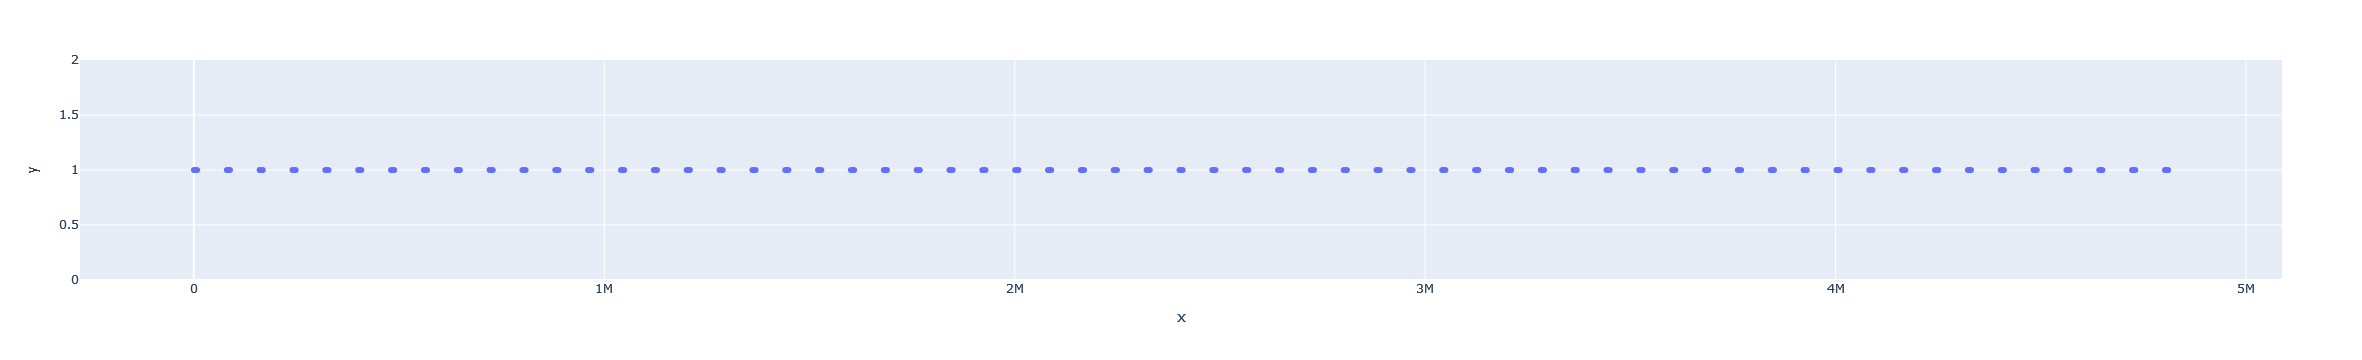

In [34]:
px.scatter(x=new_trigger[0], y=np.ones_like(new_trigger[0]))

Now we can add those trigger:

In [39]:
recording.dataframes["fff_sus_tran"] = stimulus_dfs.add_triggers(recording.dataframes["fff_sus_tran"] , ["all"], new_trigger, 6*3, 1)
recording.dataframes["fff_sus_tran"]

,index,stimulus_name,begin_fr,end_fr,trigger_fr_relative,trigger_int,stimulus_index,stimulus_repeat_logic,stimulus_repeat_sublogic,sampling_freq,recording,trigger_ends,nr_repeats
0,0,FFF,191864,4994176,"[0, 4000, 8000, 80027, 84027, 88027, 160066, 1...","[4000, 4000, 72027, 4000, 4000, 72039, 4000, 4...",0,18,1,20000.0,zebrafish_14_11_23,"[4000, 8000, 12000, 84027, 88027, 92027, 16406...",10
1,5,FFF,137207884,142010213,"[0, 4000, 8000, 80042, 84042, 88042, 160080, 1...","[4000, 4000, 72042, 4000, 4000, 72038, 4000, 4...",5,18,1,20000.0,zebrafish_14_11_23,"[4000, 8000, 12000, 84042, 88042, 92042, 16408...",10
2,17,FFF,304545052,309267327,"[0, 4000, 8000, 80029, 84029, 88029, 160068, 1...","[4000, 4000, 72029, 4000, 4000, 72039, 4000, 4...",17,18,1,20000.0,zebrafish_14_11_23,"[4000, 8000, 80029, 84029, 88029, 160067, 1640...",9
3,19,FFF,413275796,418078126,"[0, 4000, 8000, 80042, 84042, 88042, 160081, 1...","[4000, 4000, 72042, 4000, 4000, 72039, 4000, 4...",19,18,1,20000.0,zebrafish_14_11_23,"[4000, 8000, 12000, 84042, 88042, 92042, 16408...",10
4,22,FFF,425205567,430007892,"[0, 4000, 8000, 80040, 84040, 88040, 160079, 1...","[4000, 4000, 72040, 4000, 4000, 72039, 4000, 4...",22,18,1,20000.0,zebrafish_14_11_23,"[4000, 8000, 12000, 84040, 88040, 92040, 16407...",10
5,25,FFF,442532474,447334795,"[0, 4000, 8000, 80035, 84035, 88035, 160074, 1...","[4000, 4000, 72035, 4000, 4000, 72039, 4000, 4...",25,18,1,20000.0,zebrafish_14_11_23,"[4000, 8000, 12000, 84035, 88035, 92035, 16407...",10


In [3]:
spikes_df = recording.get_spikes_df(stimulus_df = "fff_sus_tran")

In [41]:
spikes_df

,cell_index,times,times_relative,trigger,repeat,times_triggered,stimulus_index
0,0,15227.25430,0.00170,0,0,0.00170,17
1,0,15227.29270,0.04010,0,0,0.04010,17
2,0,15227.30845,0.05585,0,0,0.05585,17
3,0,15227.31025,0.05765,0,0,0.05765,17
4,0,15227.31095,0.05835,0,0,0.05835,17
...,...,...,...,...,...,...,...
6061723,307,22366.42405,239.80035,17,9,23.69600,25
6061724,307,22366.48010,239.85640,17,9,23.75205,25
6061725,307,22366.55590,239.93220,17,9,23.82785,25
6061726,307,22366.63890,240.01520,17,9,23.91085,25


If we want to only have the spikes that fall inside the first 0.2 seconds of the first trigger in each repeat we can simply do:

In [44]:
import spiketrains

In [52]:
df = spiketrains.count_spikes(spikes_df, columns="trigger")
df

,trigger,spikes_sum
0,0,68033
1,1,55322
2,2,891260
3,3,74696
4,4,53967
5,5,895443
6,6,74037
7,7,52296
8,8,905782
9,9,69242


In [48]:
df.loc[0]

trigger           0
spikes_sum    68033
Name: 0, dtype: int64

In [49]:
df.loc[1]

trigger           1
spikes_sum    55322
Name: 1, dtype: int64

The third trigger will count many more spikes, as we have set a much larger time window.

Let us plot the results

In [64]:
import colour_template
import plotly_templates
CT = colour_template.Colour_template()
CT.pick_stimulus("FFF_6_MC")

<span style="font-family: monospace">#fe7c7c <span style="color: #fe7c7c">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span> <span style="font-family: monospace">#fafe7c <span style="color: #fafe7c">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span> <span style="font-family: monospace">#8afe7c <span style="color: #8afe7c">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span> <span style="font-family: monospace">#7cfcfe <span style="color: #7cfcfe">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span> <span style="font-family: monospace">#7c86fe <span style="color: #7c86fe">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span> <span style="font-family: monospace">#fe7cfe <span style="color: #fe7cfe">████</span></span> <span style="font-family: monospace">#000000 <span style="color: #000000">████</span></span>

In [57]:
# We can get the duration of each trigger:
flash_durations = stimulus_spikes.mean_trigger_times(recording.dataframes["fff_sus_tran"], ["all"])
flash_durations

array([0.2     , 0.2     , 3.601865, 0.2     , 0.2     , 3.601935,
       0.2     , 0.2     , 3.601935, 0.2     , 0.2     , 3.60194 ,
       0.2     , 0.2     , 3.60194 , 0.2     , 0.2     , 3.601945])

In [58]:
df["spikes_per_s"] = df["spikes_sum"]/flash_durations

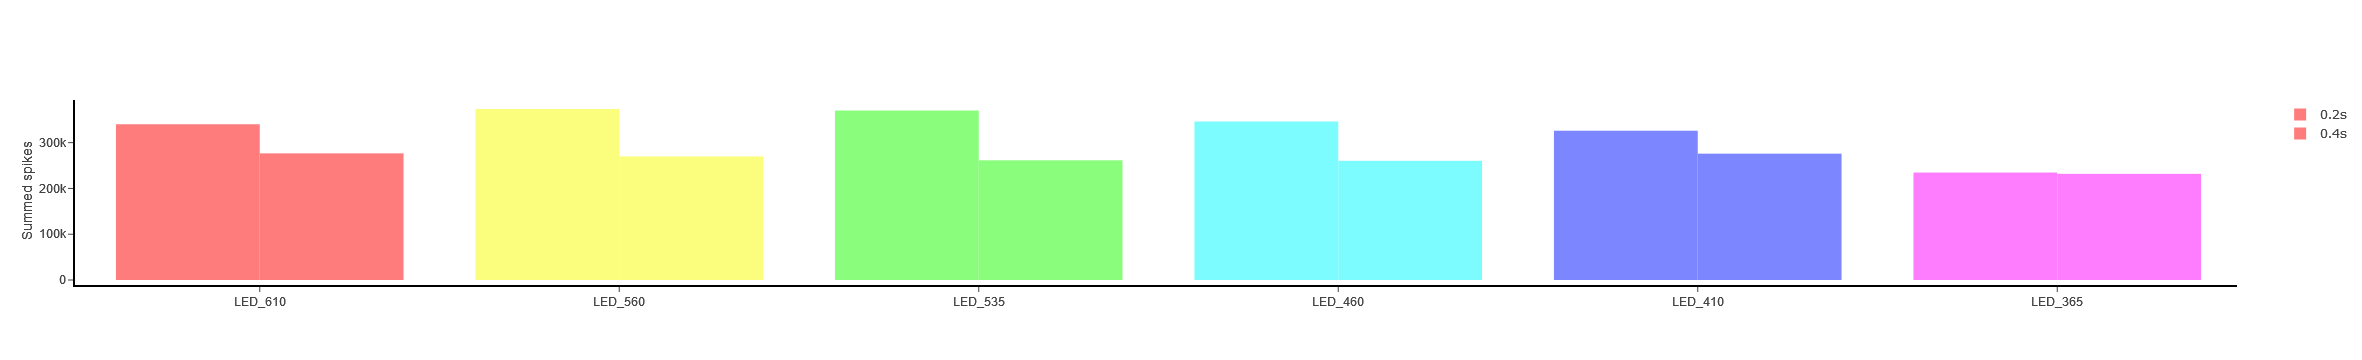

In [68]:
fig = go.Figure()
fig.add_trace(go.Bar(x=CT.names[::2], y=df["spikes_per_s"][::3], marker_color=CT.colours[::2], name="0.2s"))
fig.add_trace(go.Bar(x=CT.names[::2], y=df["spikes_per_s"][1::3], marker_color=CT.colours[::2], name="0.4s"))
fig.update_layout(template="scatter_template")
fig.update_yaxes(title="Summed spikes")

Obviously, this is only the beginning of the analysis. Ideally, one want to calculate this for each cell individually. Which is possible. This notebook only wants to give a general idea. 

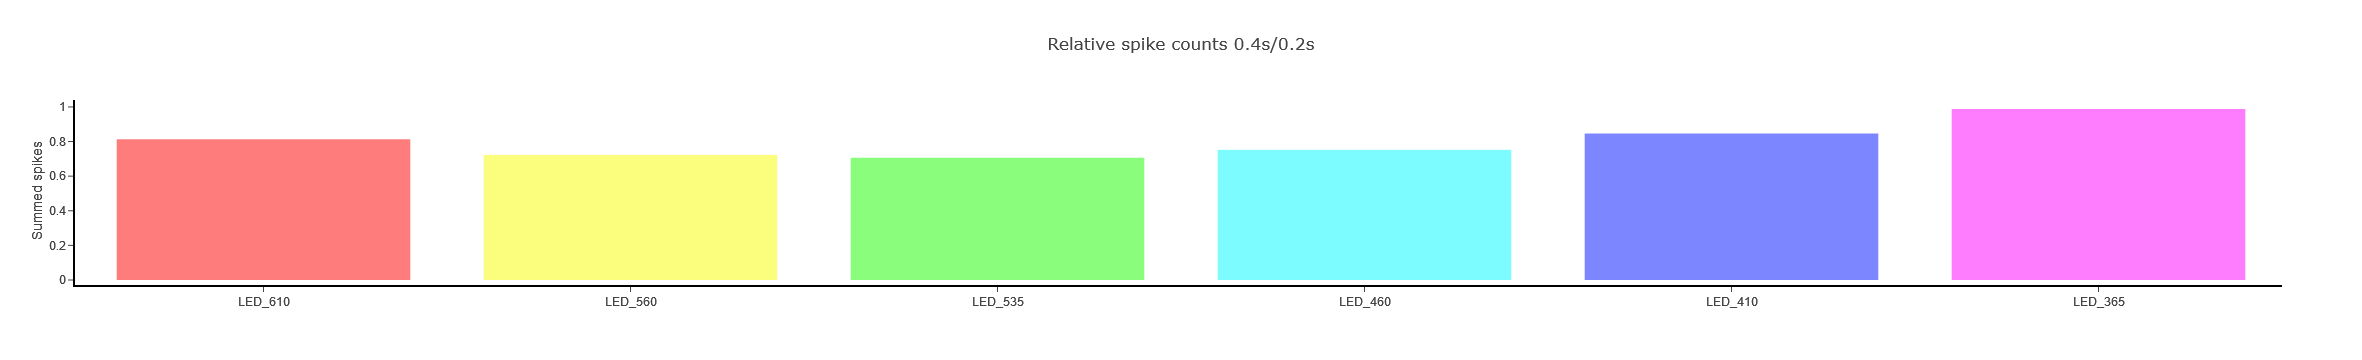

In [80]:
fig = go.Figure()
fig.add_trace(go.Bar(x=CT.names[::2], y=df["spikes_per_s"][1::3].to_numpy()/df["spikes_per_s"][::3].to_numpy(), marker_color=CT.colours[::2], name="0.2s"))
fig.update_layout(template="scatter_template", title="Relative spike counts 0.4s/0.2s")
fig.update_yaxes(title="Summed spikes")

# Advanced polars use

In [3]:
spikes_df = recording.get_spikes_df(stimulus_df = "fff_sus_tran", pandas=False)

In [4]:
dfs = spikes_df.partition_by("cell_index")

In [5]:
dfs_result = []
for df in dfs:
    df_temp = spiketrains.count_spikes(df, columns="trigger")
    df_temp = df_temp.with_columns(cell_index = pl.lit(df.unique("cell_index")["cell_index"]))
    dfs_result.append(df_temp)
    

In [6]:
df_result = pl.concat(dfs_result).to_pandas()

In [42]:
fig = px.scatter(df_result, x="trigger", y="spikes_sum")
fig.show(renderer="browser")

# Saving results:
We can save combined results in the analysis dictionary

In [7]:
recording.analysis = {}
recording.analysis["trans_sus"] = {}
recording.analysis["trans_sus"]["stimulus_df"] = "fff_sus_tran"
recording.analysis["trans_sus"]["spike_counts"] = df_result

In [9]:
recording.save(recording.load_path)

In [8]:
recording.analysis

{'trans_sus': {'stimulus_df': 'fff_sus_tran',
  'spike_counts':       trigger  spikes_sum  cell_index
  0           0         282           0
  1           1         287           0
  2           2        4694           0
  3           3         280           0
  4           4         264           0
  ...       ...         ...         ...
  5138        3           2         203
  5139        8           2         203
  5140       11           1         203
  5141       15           1         203
  5142       17           1         203
  
  [5143 rows x 3 columns]}}